## Projeto

In [73]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange
import tensorflow as tf
from tensorboard import notebook
from tensorboard import program
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
import os
import shutil
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
from sklearn.decomposition import PCA
import pickle


/tmp/ipykernel_1853928/1262273381.py:28: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


###  Exploring & understanding the features

In [74]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [75]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


In [76]:
#explore the collums of the background data
print (data_frame_bkg.columns)

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet1_BTag', 'Jet1_Eta',
       'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'MissingET_MET', 'MissingET_Phi', 'Muon_Multi', 'ScalarHT_HT',
       'gen_decay1', 'gen_decay2', 'gen_decay_filter', 'gen_filter',
       'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter',
       'gen_split', 'gen_weights', 'gen_xsec'],
      dtype='object')


In [77]:
#explore the collums of the fcnc data
print (data_frame_fcnc.columns)

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet10_BTag',
       'Jet10_Eta', 'Jet10_Mass', 'Jet10_PT', 'Jet10_Phi', 'Jet1_BTag',
       'Jet1_Eta', 'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet6_BTag', 'Jet6_Eta',
       'Jet6_Mass', 'Jet6_PT', 'Jet6_Phi', 'Jet7_BTag', 'Jet7_Eta',
       'Jet7_Mass', 'Jet7_PT', 'Jet7_Phi', 'Jet8_BTag', 'Jet8_Eta',
       'Jet8_Mass', 'Jet8_PT', 'Jet8_Phi', 'Jet9_BTag', 'Jet9_Eta',
       'Jet9_Mass', 'Jet9_PT', 'Jet9_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'Miss

In [78]:
#explore the data types of the background data
print (data_frame_bkg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1002490 entries, 0 to 1002489
Data columns (total 58 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Electron_Multi     1002490 non-null  int64  
 1   FatJet1_Eta        1002490 non-null  float64
 2   FatJet1_Mass       1002490 non-null  float64
 3   FatJet1_PT         1002490 non-null  float64
 4   FatJet1_Phi        1002490 non-null  float64
 5   FatJet1_Tau1       1002490 non-null  float64
 6   FatJet1_Tau2       1002490 non-null  float64
 7   FatJet1_Tau3       1002490 non-null  float64
 8   FatJet1_Tau4       1002490 non-null  float64
 9   FatJet1_Tau5       1002490 non-null  float64
 10  FatJet_Multi       1002490 non-null  int64  
 11  Jet1_BTag          1002490 non-null  float64
 12  Jet1_Eta           1002490 non-null  float64
 13  Jet1_Mass          1002490 non-null  float64
 14  Jet1_PT            1002490 non-null  float64
 15  Jet1_Phi           1002490 non-null  

In [79]:
#explore the data types of the fcnc data
print (data_frame_fcnc.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90548 entries, 0 to 90547
Data columns (total 83 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Electron_Multi     90548 non-null  int64  
 1   FatJet1_Eta        90548 non-null  float64
 2   FatJet1_Mass       90548 non-null  float64
 3   FatJet1_PT         90548 non-null  float64
 4   FatJet1_Phi        90548 non-null  float64
 5   FatJet1_Tau1       90548 non-null  float64
 6   FatJet1_Tau2       90548 non-null  float64
 7   FatJet1_Tau3       90548 non-null  float64
 8   FatJet1_Tau4       90548 non-null  float64
 9   FatJet1_Tau5       90548 non-null  float64
 10  FatJet_Multi       90548 non-null  int64  
 11  Jet10_BTag         90548 non-null  float64
 12  Jet10_Eta          90548 non-null  float64
 13  Jet10_Mass         90548 non-null  float64
 14  Jet10_PT           90548 non-null  float64
 15  Jet10_Phi          90548 non-null  float64
 16  Jet1_BTag          90548 no

### Histograms of Signal vs Background

#### 1. Normalize the data

In [80]:
# Z-score normalization

# copy the data to a new dataframe
data_frame_fcnc_norm = data_frame_fcnc.copy()
data_frame_bkg_norm = data_frame_bkg.copy()

# normalize the data except the categorical features and the weights
for feature in data_frame_fcnc.columns:
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split', 'gen_decay2','gen_decay1', 'gen_xsec']:
        pass
    else: 
        data_frame_fcnc_norm[feature] = (data_frame_fcnc[feature] - data_frame_fcnc[feature].mean()) / data_frame_fcnc[feature].std()
        
for feature in data_frame_bkg.columns:
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split','gen_decay2','gen_decay1','gen_xsec']:
        pass
    else:  
        data_frame_bkg_norm[feature] = (data_frame_bkg[feature] - data_frame_bkg[feature].mean()) / data_frame_bkg[feature].std()


#### 2. Plot histograms Signal Vs Background

In [81]:
# l is a list of the categorical features that are in both dataframes
l=[]
for i in data_frame_fcnc.columns:
    if  i in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split','gen_xsec']:pass
    elif i not in data_frame_bkg.columns.values: pass
    else: l.append(i)

<Figure size 640x480 with 0 Axes>

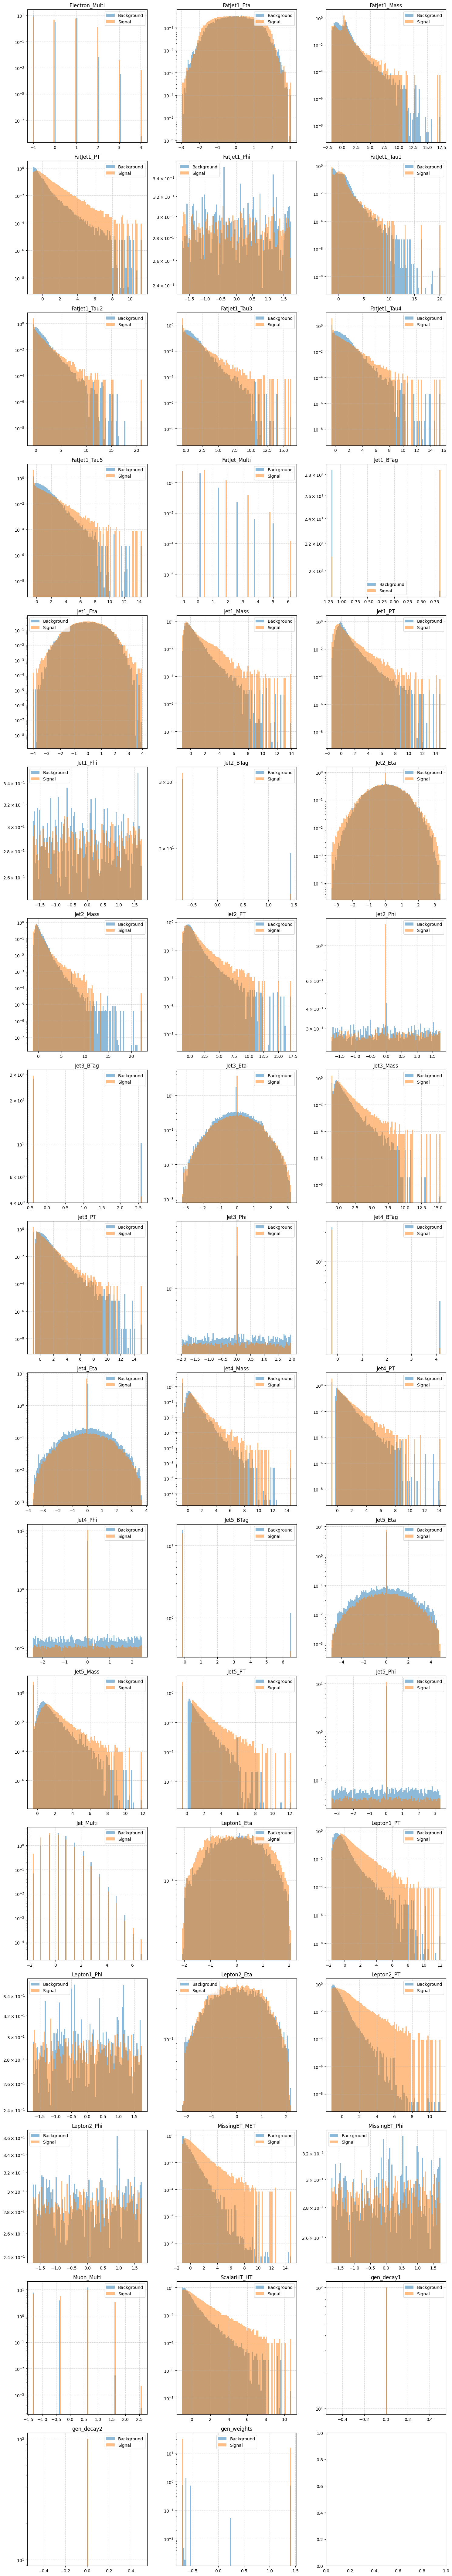

In [82]:
# Plot histograms signal vs bkg for each feature

num_features = len(data_frame_fcnc.columns)
num_cols = 3
num_rows = math.ceil(len(l) / 3)

plt.clf()

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

density = True

for i, feature in enumerate(l):
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split', 'gen_xsec']:
        continue
    elif feature not in data_frame_bkg.columns.values:
        continue
    else:
        h_sgn, b = np.histogram(data_frame_fcnc_norm[feature], bins=100, density=density, weights=data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_label'] == 'signal', 'gen_xsec'])
        h_bkg, _ = np.histogram(data_frame_bkg_norm[feature], bins=100, density=density, weights=data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_label'] == 'bkg', 'gen_xsec'])

        bincentres = [(b[i] + b[i+1]) / 2. for i in range(len(b)-1)]
        binwidth = b[1] - b[0]

        axes[i // num_cols, i % num_cols].grid(True, linestyle='--', alpha=0.5)
        axes[i // num_cols, i % num_cols].set_title(feature)
        axes[i // num_cols, i % num_cols].bar(bincentres, h_bkg, label="Background", width=binwidth, color="tab:blue", alpha=0.5)
        axes[i // num_cols, i % num_cols].bar(bincentres, h_sgn, bottom=h_bkg if not density else 0, label="Signal", width=binwidth, color="tab:orange", alpha=0.5)
        axes[i // num_cols, i % num_cols].set_yscale("log")
        axes[i // num_cols, i % num_cols].legend()

fig.tight_layout()
plt.show()

### Data preprocessing 

In [83]:
def perform_PCA (DataFeatures, pca_n_features, train, data):
    ## Fit PCA to train data & rank components by AUC
    pca = PCA(n_components=len(DataFeatures))
    pca.fit(train[DataFeatures])

    ## Transform the desired dataset to get its principal components
    # Get ranked components by AUC from the train data
    principalComponents = pca.transform(train[DataFeatures])

    # Book will be a dictiorary with the AUC (values) of each component (keys)
    book = {}

    # Get values for AUC computation
    y_true = train['gen_label'].values
    weights = train["gen_xsec"].values

    # Renormalise weights
    weights[y_true == 1] = (weights[y_true == 1] / weights[y_true == 1].sum()) * weights.shape[0] / 2
    weights[y_true == 0] = (weights[y_true == 0] / weights[y_true == 0].sum()) * weights.shape[0] / 2

    for feature_idx in range(principalComponents.shape[1]):
        book[f"Component {feature_idx}"] = roc_auc_score(y_true=y_true, y_score=principalComponents[:, feature_idx], sample_weight=weights)

    # Give me the best features
    book = pd.DataFrame.from_dict(book, orient="index")
    book.columns = ["AUC"]
    book.sort_values(by="AUC", ascending=False, inplace=True)
    book.reset_index(inplace=True)
    book.rename(columns={"index": "Feature"}, inplace=True)

    ## Replace current data by its components ##
    # Get components for the current set we want
    principalComponents = pca.transform(data[DataFeatures])

    # Create a new dataframe with PCA data
    newdf = pd.DataFrame(principalComponents, columns=[f"Component {i}" for i in range(principalComponents.shape[1])])

    # Select the best components given their AUC performance in training data
    newdf = newdf[book["Feature"][0 : pca_n_features]]

    # Add the other relevant features
    newdf["gen_xsec"] = data["gen_xsec"].values
    newdf["gen_label"] = data["gen_label"].values
    newdf["gen_split"] = data["gen_split"].values

    # Finally, replace self.data with newdf
    data = newdf

    # Update DataFeatures
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
    
    return data, DataFeatures, book


In [84]:
def train_val_test(n_datapoints,n_batches,n_features,method,type):
    data_frame_fcnc_pca = data_frame_fcnc.copy()
    data_frame_bkg_pca = data_frame_bkg.copy()

    # Drop the categorical features except label, weights and gen_split
    data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
    data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

    # Drop the features that are not in both dataframes
    for feature in data_frame_fcnc_pca.columns.values:
        if feature not in data_frame_bkg_pca.columns.values:
            data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

    for feature in data_frame_bkg_pca.columns.values:
        if feature not in data_frame_fcnc_pca.columns.values:
            data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
    # Join the dataframes
    data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

    # Substitute the labels "signal" and "bkg" by 1 and 0
    data = data.replace(['signal'], 1)
    data= data.replace(['bkg'], 0)

    # train set
    train = data.loc[data['gen_split'] == 'train']
    
    # which data will be used for fitting the PCA.
    # Everything except the weights, name and label
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))

    
    if method == "pca":
        # perform PCA on the train data
        data, DataFeatures, book = perform_PCA (DataFeatures,n_features, train, data)
        
    elif method == "sbs":
        Features = ['MissingET_MET', 'FatJet1_Tau1','FatJet1_Tau3','Jet2_PT','Jet1_PT']
        DataFeatures = Features[:n_features]
        
    if type == "ml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()
        
    elif type == "qml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (((data[DataFeatures] - data[DataFeatures].min()) / (data[DataFeatures].max() - data[DataFeatures].min())) * 2 - 1) * (np.pi)
  
    # divide the new data into train, test and validation sets
    train = data.loc[data['gen_split'] == 'train']
    test = data.loc[data['gen_split'] == 'test']
    val = data.loc[data['gen_split'] == 'val']

    # divide the train data into signal and background and get n_datapoints/2*n_batches samples of each set
    train_sgn = train.loc[train['gen_label'] == 1].sample(n=int(n_datapoints/2 * n_batches),random_state=46)
    train_bkg = train.loc[train['gen_label'] == 0].sample(n=int(n_datapoints/2* n_batches),random_state=46)
    x_train_batches = [pd.concat([train_sgn[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)], train_bkg[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)]]) for i in range(n_batches)]
    for i in range(n_batches):
        x_train_batches[i] = x_train_batches[i].sample(frac=1, random_state=46)

    # divide the validation data into signal and background and get n_datapointss/2*n_batches samples of each set
    val_sgn = val.loc[val['gen_label'] == 1].sample(n=int(n_datapoints/2*n_batches), random_state=46)
    val_bkg = val.loc[val['gen_label'] == 0].sample(n=int (n_datapoints/2*n_batches), random_state=46)
    x_val_batches = [pd.concat([val_sgn[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)], val_bkg[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)]]) for i in range(n_batches)]
    for i in range(n_batches):
        x_val_batches[i] = x_val_batches[i].sample(frac=1, random_state=46)

    # divide the test data into signal and background and get n_datapoints/2*n_batches samples of each set
    test_sgn = test.loc[test['gen_label'] == 1].sample(n=int(n_datapoints/2*n_batches), random_state=46)
    test_bkg = test.loc[test['gen_label'] == 0].sample(n=int(n_datapoints/2*n_batches), random_state=46)
    x_test_batches = [pd.concat([test_sgn[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)], test_bkg[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)]]) for i in range(n_batches)]
    for i in range(n_batches):
        x_test_batches[i] = x_test_batches[i].sample(frac=1, random_state=46)

    # get an array with the labels for each set
    y_train_batches = [x_train_batches[i]['gen_label'].values for i in range(n_batches)]
    y_val_batches = [x_val_batches[i]['gen_label'].values for i in range(n_batches)]
    y_test_batches = [x_test_batches[i]['gen_label'].values for i in range(n_batches)]

    # get an array with the weights for each set
    w_train_batches = [x_train_batches[i]['gen_xsec'].values for i in range(n_batches)]
    w_val_batches = [x_val_batches[i]['gen_xsec'].values for i in range(n_batches)]
    w_test_batches = [x_test_batches[i]['gen_xsec'].values for i in range(n_batches)]

    # get an array with the features for each set
    x_train_batches = [x_train_batches[i][DataFeatures].values for i in range(n_batches)]
    x_val_batches = [x_val_batches[i][DataFeatures].values for i in range(n_batches)]
    x_test_batches = [x_test_batches[i][DataFeatures].values for i in range(n_batches)]
    
    # Renormalize weights (for each batch)
    for i in range(n_batches):
        w_train_batches[i][y_train_batches[i]==1] = w_train_batches[i][y_train_batches[i]==1] / w_train_batches[i][y_train_batches[i]==1].sum() * w_train_batches[i].shape[0] / 2
        w_train_batches[i][y_train_batches[i]==0] = w_train_batches[i][y_train_batches[i]==0] / w_train_batches[i][y_train_batches[i]==0].sum() * w_train_batches[i].shape[0] / 2
        w_test_batches[i][y_test_batches[i]==1] = w_test_batches[i][y_test_batches[i]==1] / w_test_batches[i][y_test_batches[i]==1].sum() * w_test_batches[i].shape[0] / 2
        w_test_batches[i][y_test_batches[i]==0] = w_test_batches[i][y_test_batches[i]==0] / w_test_batches[i][y_test_batches[i]==0].sum() * w_test_batches[i].shape[0] / 2
        w_val_batches[i][y_val_batches[i]==1] = w_val_batches[i][y_val_batches[i]==1] / w_val_batches[i][y_val_batches[i]==1].sum() * w_val_batches[i].shape[0] / 2
        w_val_batches[i][y_val_batches[i]==0] = w_val_batches[i][y_val_batches[i]==0] / w_val_batches[i][y_val_batches[i]==0].sum() * w_val_batches[i].shape[0] / 2
    
    return x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches

### SVM

In [85]:
def train_svm (x_train,y_train, w_train):
    clf = svm.SVC(kernel='rbf', C= 1000, gamma= 0.001, probability=True) 
    clf.fit(x_train, y_train,sample_weight=w_train)
    return clf

def val_svm (clf, x_val, y_val, w_val):
    y_pred = clf.predict(x_val)
    y_pred_prob = clf.predict_proba(x_val)[:,1]
    auc = roc_auc_score(y_val, y_pred_prob, sample_weight=w_val)
    return auc

def test_svm (clf, x_test, y_test, w_test):
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_prob, sample_weight=w_test)
    return auc

def test_svm_E (clf, x_test, y_test, w_test):
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    return y_pred_prob

In [86]:
n_features = 5
n_datapoints = 4000
x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,n_features,'pca','ml')
x_test = np.concatenate(x_test_batches)
y_test = np.concatenate(y_test_batches)
w_test= np.concatenate(w_test_batches)
y_pred_prob_val_list = []
y_pred_prob_test_list= []
auc_val_list = []
auc_test_list = []
fpr_test_batches=[]
tpr_test_batches=[]
yscores_list_E = []
for i in range (5):
    clf = train_svm(x_train_batches[i],y_train_batches[i], w_train_batches[i])
    auc_val_list.append(val_svm(clf, x_val_batches[i], y_val_batches[i], w_val_batches[i]))
    auc_test_list.append(test_svm(clf, x_test_batches[i], y_test_batches[i], w_test_batches[i]))
    y_pred = test_svm_E(clf, x_test_batches[i], y_test_batches[i], w_test_batches[i])
    y_pred_prob_test_list.append(y_pred)
    fpr, tpr, _ = roc_curve(y_test_batches[i],y_pred , sample_weight=w_test_batches[i])
    fpr_test_batches.append(fpr)
    tpr_test_batches.append(tpr)
    #Ensemble
    yscores_list_E.append(test_svm_E(clf, x_test, y_test, w_test))
    
auc_val = np.mean(auc_val_list)
auc_val_std = np.std(auc_val_list)
auc_test = np.mean(auc_test_list)
auc_test_std = np.std(auc_test_list)
print('N_components: {}'.format(n_features), 'N_datapoints: {}'.format(n_datapoints))
print('AUC Val: {}'.format(auc_val))
print ('AUC Val std: {}'.format(auc_val_std))
print('AUC Test: {}'.format(auc_test))
print ('AUC Test std: {}'.format(auc_test_std))
# Ensemble
yscores_E = np.mean(yscores_list_E, axis=0)
ensemble_auc_test = roc_auc_score(y_test, yscores_E, sample_weight=w_test)
fpr_E, tpr_E, _ = roc_curve(y_test, yscores_E, sample_weight=w_test)
print ('Ensemble AUC Test: {}'.format(ensemble_auc_test))
print('')

N_components: 5 N_datapoints: 4000
AUC Val: 0.8912853888137026
AUC Val std: 0.02042258305596663
AUC Test: 0.8883832258251301
AUC Test std: 0.014163285486495151
Ensemble AUC Test: 0.8908708228889813



ROC AUC Score: 0.8883832258251301
ROC AUC std: 0.014163285486495151


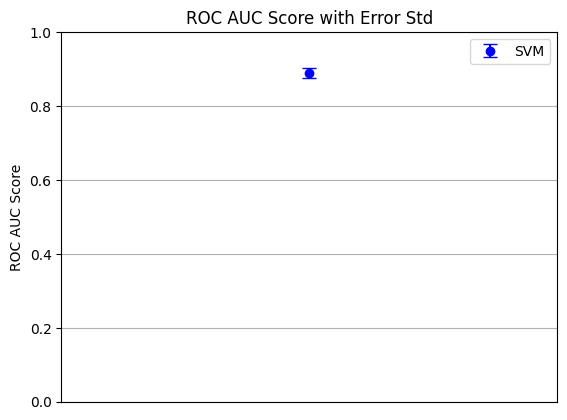

In [87]:
# Compute metric
print("ROC AUC Score:", auc_test)
print ("ROC AUC std:", auc_test_std)

# Plot the ROC AUC score with error bar
plt.errorbar(0, auc_test, yerr=auc_test_std, fmt='o', color='b', capsize=5, label='SVM')

plt.xticks([])

plt.ylim(0, 1)
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score with Error Std')
plt.grid(axis='y')
plt.legend()
plt.show()

/tmp/ipykernel_1853928/1985296317.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


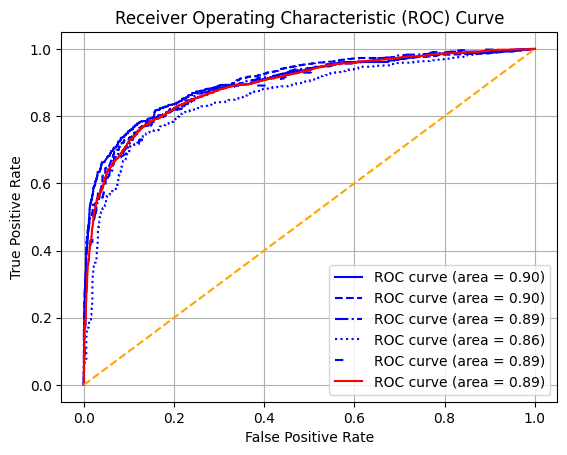

In [88]:
line_styles = ['-', '--', '-.', ':']  # Define different line styles
color = 'blue' 
for i in range(4):
    # Plot the ROC curve with a different line style for each curve
    plt.plot(fpr_test_batches[i], tpr_test_batches[i], linestyle=line_styles[i], color = color,label='ROC curve (area = %0.2f)' % auc_test_list[i])

plt.plot(fpr_test_batches[4], tpr_test_batches[4], linestyle='--',dashes = (4,10), color = color, label='ROC curve (area = %0.2f)' % auc_test_list[4])
plt.plot(fpr_E, tpr_E, linestyle='-', color = 'red', label='ROC curve (area = %0.2f)' % ensemble_auc_test)
# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
# Add grid to the plot
plt.grid(True)
plt.show()

[2.39731168e+01 1.16386973e+02 3.40365375e+02 3.87857799e+02
 1.75207332e+02 1.57715330e+02 2.14635238e+02 1.30944053e+02
 1.16031734e+02 9.04553875e+01 5.92054006e+01 4.27513245e+01
 2.89867195e+01 3.89429705e+01 2.04430347e+01 1.24882320e+01
 6.90383603e+00 1.03954629e+01 2.90688158e+00 4.06028326e+00
 3.04322249e+00 2.98571565e+00 2.80600621e+00 1.07198983e+00
 2.74425747e+00 1.91589518e+00 1.88545497e+00 9.26231270e-01
 4.33580904e-02 1.92138470e+00]
[  4.  11.  23.  44.  46.  51.  48.  64.  65.  86.  68.  69.  50.  68.
  78.  53.  59.  60.  70.  58.  60.  54.  53.  66.  63.  59.  84.  89.
  98. 299.]


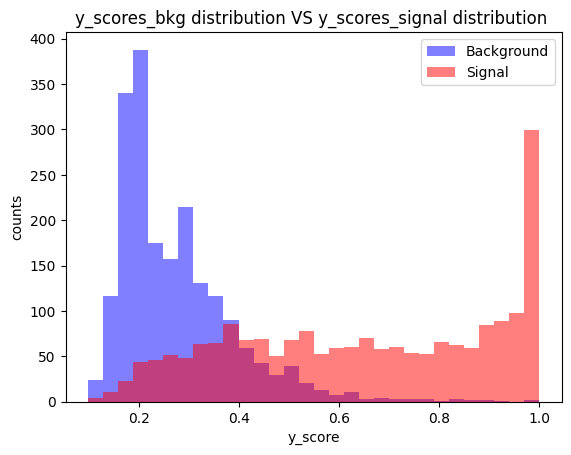

In [89]:
# Plot signal and background distributions for the predicted scores with normalized counts and log scale

num_bins = 30  # Number of bins

# Compute the range for the bins based on the minimum and maximum values of the data
min_value = min(min(y_pred_prob_test_list[0][y_test_batches[0] == 1]), min(y_pred_prob_test_list[0][y_test_batches[0]== 0]))
max_value = max(max(y_pred_prob_test_list[0][y_test_batches[0] == 1]), max(y_pred_prob_test_list[0] [y_test_batches[0]== 0]))
bin_range = (min_value, max_value)

counts, bins, _ = plt.hist(y_pred_prob_test_list[0][y_test_batches[0] == 0], bins=num_bins, range=bin_range,  weights=w_test_batches[0][y_test_batches[0]==0], alpha=0.5, color='b', label='Background')
counts2, bins2, _ = plt.hist(y_pred_prob_test_list[0][y_test_batches[0]  == 1], bins=num_bins, range=bin_range,weights=w_test_batches[0][y_test_batches[0] ==1], alpha=0.5, color='r', label='Signal')

print(counts)
print(counts2)

plt.xlabel('y_score')
plt.ylabel('counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

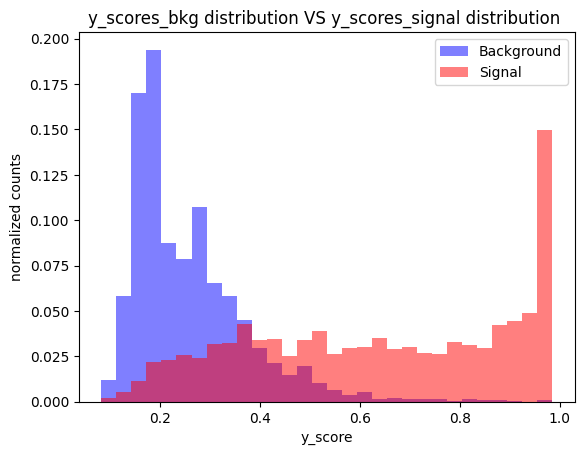

In [90]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

### VQC

In [91]:
'''
if os.path.exists('./logs/train_val'):
    shutil.rmtree('./logs/train_val')

# Create a summary writer for logging the loss
train_val_writer = tf.summary.create_file_writer('./logs/train_val')

# Create a TensorBoard server
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', './logs'])
url = tb.launch()

# Print the TensorBoard URL
print("TensorBoard URL:", url)
'''

'\nif os.path.exists(\'./logs/train_val\'):\n    shutil.rmtree(\'./logs/train_val\')\n\n# Create a summary writer for logging the loss\ntrain_val_writer = tf.summary.create_file_writer(\'./logs/train_val\')\n\n# Create a TensorBoard server\ntb = program.TensorBoard()\ntb.configure(argv=[None, \'--logdir\', \'./logs\'])\nurl = tb.launch()\n\n# Print the TensorBoard URL\nprint("TensorBoard URL:", url)\n'

In [92]:
# accuracy function
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


In [93]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# quantum circuit function
def circuit(n_features, n_layers, weights, x):
        # Embedding
        
        qml.AngleEmbedding(x,range (0, n_features),rotation="X" )

        # For every layer
        for layer in range(n_layers):
            W1 = weights[layer]

            # Define Rotations
            for i in range(0,n_features):
                qml.Rot(W1[i, 0], W1[i, 1], W1[i, 2], wires=i)

            # Entanglement
            if n_features != 1:
                if n_features > 2:
                    for i in range(n_features):
                        if i == n_features - 1:
                            qml.CNOT(wires=[i, 0])
                        else:
                            qml.CNOT(wires=[i, i + 1])
                else:
                    qml.CNOT(wires=[1, 0])

        return qml.expval(qml.PauliZ(0))

# classifier function    
def classifier(n_features, n_layers, weights, x):
        #c = circuit(n_features, n_layers, weights, x)
        dev=qml.device("default.qubit", wires=n_features)
        return qml.QNode(circuit, dev)(n_features, n_layers, weights, x)
    
# cost function    
def cost(n_features, n_layers,weights,X,Y,W):  
        # Compute predictions
        y_scores = [(classifier(n_features, n_layers,weights, x) + 1) / 2 for x in X]

        loss = square_loss(Y, y_scores)
        loss = loss * W
        loss = loss.sum()
        
        return loss
    
# train step function    
def train_step(n_features, n_layers,x_train,y_train, w_train, weights, opt,desc='Training'):
        
        # Only require grad if necessary
        x_train = np.array(x_train, requires_grad=False)
        y_train = np.array(y_train, requires_grad=True)
        w_train = np.array(w_train, requires_grad=False)

        # Compute cost and update weights
        weights, loss = opt.step_and_cost(cost, n_features, n_layers,weights, X=x_train, Y=y_train, W=w_train)

        return loss, weights
    
# validation step function
def validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch,best_weights,desc='Validation'):
    X_val = np.array(x_val, requires_grad=False)
    Y_val = np.array(y_val, requires_grad=False)
    W_val = np.array(w_val, requires_grad=False)

    y_scores = np.array([classifier(n_features, n_layers, weights, x) for x in X_val])
    y_scores = (y_scores + 1) / 2

    W_val[Y_val == 1] = (W_val[Y_val == 1] / W_val[Y_val == 1].sum()) * W_val.shape[0] / 2
    W_val[Y_val == 0] = (W_val[Y_val == 0] / W_val[Y_val == 0].sum()) * W_val.shape[0] / 2

    auc_score = roc_auc_score(y_true=Y_val, y_score=y_scores, sample_weight=W_val)
    loss = cost(n_features, n_layers, weights, X_val, Y_val, W_val)


    if best_score is None or auc_score > best_score:
        best_score = auc_score
        best_score_epoch = epoch_number
        best_weights = weights

    tqdm.write(f"Epoch: {epoch_number}, Validation Loss: {loss:.4f}, AUC Score: {auc_score:.4f}")

    return best_score, best_score_epoch, best_weights
        
        
# train function
def train_vqc(n_features, n_layers, x_train, y_train,w_train,x_val,y_val,w_val, learning_rate, weights, max_epochs):
    opt = AdamOptimizer(learning_rate)
    best_score = None
    best_weights = None
    best_score_epoch = None
    epoch_number = 0

    with tqdm(total=max_epochs, desc='Epoch', unit='epoch') as pbar:
        for epoch in range(epoch_number, max_epochs):
            epoch_number = epoch

            loss, nf_nl_weights = train_step(n_features, n_layers, x_train, y_train, w_train, weights, opt, desc='Training')
            
            # Log variable values using tqdm.write
            tqdm.write(f"Epoch: {epoch_number:}, Loss: {loss:.4f}")
            
            
            weights = nf_nl_weights[2:]
            weights = weights[0]

            if epoch_number == max_epochs - 1 or (epoch_number+1)%5==0:
                best_score, best_score_epoch, best_weights = validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch, best_weights,desc='Validation')
                # early stopping
                if epoch_number - best_score_epoch > 20 and epoch_number > 60:
                    tqdm.write(f"Early stopping at epoch {epoch_number}")
                    break

            pbar.update(1)  # Update progress bar
        tqdm.write(f"Best Score: {best_score:.4f}")            
        
    return best_score, best_weights


def test_vqc(n_features, n_layers,x_test,y_test,w_test, weights):
        # Remove grad
        X_test = np.array(x_test, requires_grad=False)
        Y_test = np.array(y_test, requires_grad=False)
        W_test = np.array(w_test, requires_grad=False)

        # This will be between -1 and 1, we need to convert to between 0 and 1
        y_scores = np.array([classifier(n_features, n_layers,weights, x) for x in X_test])
        y_scores = (y_scores + 1) / 2

        # Renormalize weights
        W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
        W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2

        # Calculate ROC
        #auc_score = roc_auc_score(y_true=Y_test, y_score=y_scores, sample_weight=W_test)
        
        return y_scores

In [94]:
'''
n_features = 2
n_layers = 3
n_datapoints = 1000
x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,n_features,'sbs','qml')
y_pred_prob_val_list = []
y_pred_prob_test_list= []
auc_val_list = []
auc_test_list = []
fpr_test_batches=[]
tpr_test_batches=[]
for i in range (5):
    # Random weight initialization
    weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)
    # We create a quantum device with n_features "wires" (or qubits)
    dev = qml.device('default.qubit', wires=n_features)
    # train the model
    best_score, best_weights = train_vqc(n_features, n_layers,x_train_batches[i],y_train_batches[i],w_train_batches[i], x_val_batches[i],y_val_batches[i],w_train_batches[i],0.01, weights, 5)
    #test
    y_pred_prob_val_list.append(test_vqc(n_features, n_layers,x_val_batches[i],y_val_batches[i],w_val_batches[i], best_weights))
    y_pred_prob_test_list.append(test_vqc(n_features, n_layers,x_test_batches[i],y_test_batches[i],w_test_batches[i],best_weights))
   
media_y_pred_prob_val= np.mean(y_pred_prob_val_list, axis=0)
media_y_pred_prob_test= np.mean(y_pred_prob_test_list, axis=0)
for i in range (5):
    auc_val_list.append(roc_auc_score(y_val_batches[i],media_y_pred_prob_val, sample_weight=w_val_batches[i]))
    auc_test_list.append(roc_auc_score(y_test_batches[i],media_y_pred_prob_test, sample_weight=w_test_batches[i]))
    fpr, tpr, thresholds = roc_curve(y_test_batches[i], media_y_pred_prob_test,sample_weight=w_test_batches[i])
    fpr_test_batches.append(fpr)
    tpr_test_batches.append(tpr)
auc_val_sim = np.mean(auc_val_list)
auc_val_sim_std = np.std(auc_val_list)
auc_sim_test = np.mean(auc_test_list)
auc_test_sim_std = np.std(auc_test_list)
print('N_components: {}'.format(n_features), 'N_datapoints: {}'.format(n_datapoints))
print('AUC Val: {}'.format(auc_val_sim))
print ('AUC Val std: {}'.format(auc_val_sim_std))
print('')
print('AUC Test: {}'.format(auc_sim_test))
print ('AUC Test std: {}'.format(auc_test_sim_std))
print('')
'''

'\nn_features = 2\nn_layers = 3\nn_datapoints = 1000\nx_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,n_features,\'sbs\',\'qml\')\ny_pred_prob_val_list = []\ny_pred_prob_test_list= []\nauc_val_list = []\nauc_test_list = []\nfpr_test_batches=[]\ntpr_test_batches=[]\nfor i in range (5):\n    # Random weight initialization\n    weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)\n    # We create a quantum device with n_features "wires" (or qubits)\n    dev = qml.device(\'default.qubit\', wires=n_features)\n    # train the model\n    best_score, best_weights = train_vqc(n_features, n_layers,x_train_batches[i],y_train_batches[i],w_train_batches[i], x_val_batches[i],y_val_batches[i],w_train_batches[i],0.01, weights, 5)\n    #test\n    y_pred_prob_val_list.append(test_vqc(n_features, n_layers,x_val_batches[i],y_val_batches[i],w_val_batches[i]

In [95]:
with open ('dict_tarefa_variabilidade_sim.pickle', 'rb') as f:
    dict = pickle.load(f)
    
auc_val_sim = dict['auc_val_sim']
auc_val_sim_std = dict['auc_val_sim_std']
auc_test_sim = dict['auc_test_sim']
auc_test_sim_std=dict['auc_test_sim_std']
fpr_test_batches_sim = dict['fpr_test_batches_sim']
tpr_test_batches_sim = dict['tpr_test_batches_sim']
yscores_E_sim = dict['yscores_E_sim']
ensemble_auc_test_sim =dict['ensemble_auc_test_sim'] 
fpr_E_sim  = dict['fpr_E_sim']
tpr_E_sim = dict['tpr_E_sim']
y_pred_prob_test_list_sim = dict['y_pred_prob_test_list_sim']
auc_test_list_sim = dict['auc_test_list_sim']

ROC AUC Score: 0.2690511737371473
ROC AUC std: 0.03593229589163783


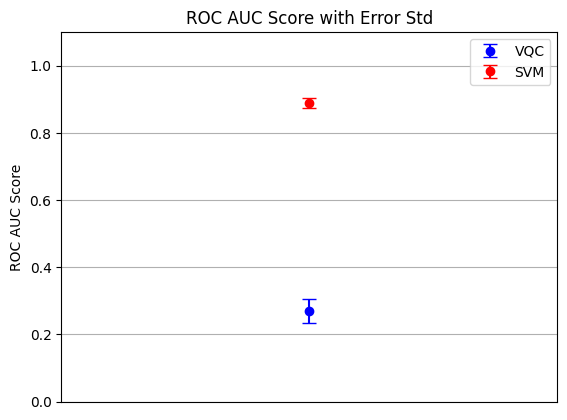

In [96]:
# Compute metric
print("ROC AUC Score:", auc_test_sim)
print ("ROC AUC std:", auc_test_sim_std)

# Plot the ROC AUC score with error bar for both svm and vqc
plt.errorbar(0,  auc_test_sim, yerr=auc_test_sim_std, fmt='o', color='b', capsize=5, label='VQC')
plt.errorbar(0, auc_test, yerr=auc_test_std, fmt='o', color='r', capsize=5, label='SVM')

plt.xticks([])

plt.ylim(0, 1.1)
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score with Error Std')
plt.grid(axis='y')
plt.legend()
plt.show()

#### Real Device

In [97]:
'''
# remove existing logs
if os.path.exists('./logs/train_val'):
    shutil.rmtree('./logs/train_val')
'''

"\n# remove existing logs\nif os.path.exists('./logs/train_val'):\n    shutil.rmtree('./logs/train_val')\n"

In [98]:
# Save your credentials on disk.
#IBMProvider.save_account(token='89d169bf0ad41245806d22338e0458557da47dab398645d14ec77cae3d506133376707f89bf393b51dcdf0a91e1bbd3efa9e680822a5e953d0fc4315ad9a491c', overwrite=True)

provider = IBMProvider(instance='ibm-q/open/main')

In [99]:
from qiskit.providers.ibmq import least_busy


# Load your IBM Quantum Experience account credentials
provider = IBMProvider(instance='ibm-q/open/main')


# Get a list of available backends from the provider
backends = provider.backends()

# Print the names of all available backends
print("Available Backend Names:")
for backend in backends:
    print(backend.name)


Available Backend Names:
ibmq_qasm_simulator
simulator_extended_stabilizer
simulator_mps
simulator_stabilizer
ibm_nairobi
ibm_lagos
ibm_perth
ibmq_jakarta
ibmq_quito
ibmq_lima
ibmq_belem
simulator_statevector
ibmq_manila


In [100]:
# Get a list of available backend names from the provider
backend_names = [backend.name for backend in provider.backends()]

# Get the backend objects corresponding to the available backend names
backends = [provider.get_backend(name) for name in backend_names]

# Get the least busy backend
least_busy_backend = least_busy(backends)

# Print information about the least busy backend
print("Least Busy Backend:")
print("Name:", least_busy_backend)
print("Number of active jobs:", least_busy_backend.status().pending_jobs)

Least Busy Backend:
Name: <IBMBackend('ibmq_qasm_simulator')>
Number of active jobs: 0


In [101]:
with open ('dict_tarefa_variabilidade_real.pickle', 'rb') as f:
    dict = pickle.load(f)

auc_val_real = dict['auc_val_real']
auc_val_real_std = dict['auc_val_real_std']
auc_test_real = dict['auc_test_real']
auc_test_real_std =dict['auc_test_real_std']
fpr_test_batches_real = dict['fpr_test_batches_real']
tpr_test_batches_real = dict['tpr_test_batches_real']
yscores_E_real = dict['yscores_E_real']
ensemble_auc_test_real =dict['ensemble_auc_test_real'] 
fpr_E_real  = dict['fpr_E_real']
tpr_E_real = dict['tpr_E_real']
y_pred_prob_test_list_sim = dict['y_pred_prob_test_list_real']
auc_test_list_real = dict['auc_test_list_real']

ROC AUC Score: 0.2691219261124454
ROC AUC std: 0.03597792328166331


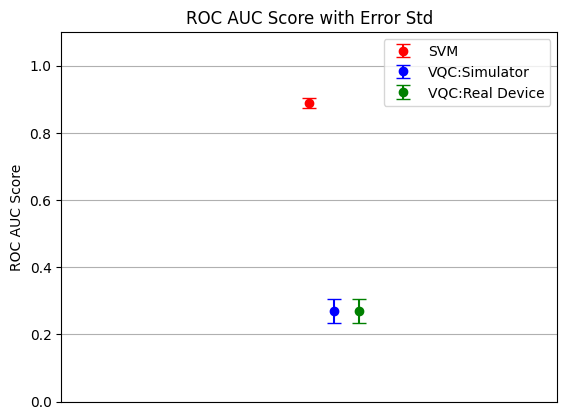

In [102]:
# Compute metric
print("ROC AUC Score:", auc_test_real)
print ("ROC AUC std:", auc_test_real_std)

# Plot the ROC AUC score with error bar for both svm and vqc
plt.errorbar(0, auc_test, yerr=auc_test_std, fmt='o', color='r', capsize=5, label='SVM')
# Now with a small ofset on the x axis
plt.errorbar(0.1,  auc_test_sim, yerr=auc_test_sim_std, fmt='o', color='b', capsize=5, label='VQC:Simulator')
plt.errorbar(0.2, auc_test_real, yerr=auc_test_real_std, fmt='o', color='g', capsize=5, label='VQC:Real Device')

plt.xticks([])
plt.xlim(-1, 1)
plt.ylim(0, 1.1)
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score with Error Std')
plt.grid(axis='y')
plt.legend()
plt.show()

#### Simulator with noise

In [103]:
provider = IBMProvider(instance='ibm-q/open/main')
backend = provider.get_backend('ibmq_quito')

# Get the noise model for ibmq_quito
noise_model = NoiseModel.from_backend(backend)


In [104]:
with open ('dict_tarefa_variabilidade_sim_noise.pickle', 'rb') as f:
    dict = pickle.load(f)
auc_val_sim_noise = dict['auc_val_sim_noise']
auc_val_sim_noise_std = dict['auc_val_sim_noise_std']
auc_test_sim_noise = dict['auc_test_sim_noise']
auc_test_sim_noise_std=dict['auc_test_sim_noise_std']
fpr_test_batches_sim_noise = dict['fpr_test_batches_sim_noise']
tpr_test_batches_sim_noise = dict['tpr_test_batches_sim_noise']
y_scores_E_sim_noise = dict['yscores_E_sim_noise']
ensemble_auc_test_sim_noise =dict['ensemble_auc_test_sim_noise']
fpr_E_sim_noise = dict['fpr_E_sim_noise']
tpr_E_sim_noise = dict['tpr_E_sim_noise']
y_pred_prob_test_list_sim_noise = dict['y_pred_prob_test_list_sim_noise']
auc_test_list_sim_noise = dict['auc_test_list_sim_noise']


ROC AUC Score: 0.2687177430793282
ROC AUC std: 0.036080560426545887


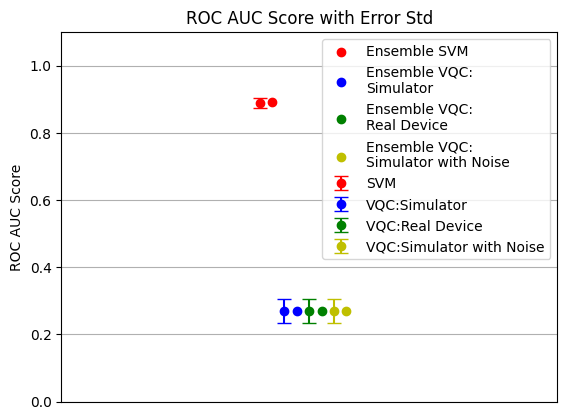

In [105]:

# Compute metric
print("ROC AUC Score:", auc_test_sim_noise)
print ("ROC AUC std:", auc_test_sim_noise_std)

# Plot the ROC AUC score with error bar for both svm and vqc
plt.errorbar(0, auc_test, yerr=auc_test_std, fmt='o', color='r', capsize=5, label='SVM')
plt.scatter(0.05, ensemble_auc_test, color='r',  label='Ensemble SVM')
plt.errorbar(0.1,  auc_test_sim, yerr=auc_test_sim_std, fmt='o', color='b', capsize=5, label='VQC:Simulator')
plt.scatter(0.15, ensemble_auc_test_sim,  color='b',  label='Ensemble VQC:\nSimulator')
plt.errorbar(0.2, auc_test_real, yerr=auc_test_real_std, fmt='o', color='g', capsize=5, label='VQC:Real Device')
plt.scatter(0.25, ensemble_auc_test_real,  color='g', label='Ensemble VQC:\nReal Device')
plt.errorbar(0.3, auc_test_sim_noise, yerr=auc_test_sim_noise_std, fmt='o', color='y', capsize=5, label='VQC:Simulator with Noise')
plt.scatter(0.35, ensemble_auc_test_sim_noise,  color='y',  label='Ensemble VQC:\nSimulator with Noise')

plt.xticks([])
plt.xlim(-0.8, 1.2)
plt.ylim(0, 1.1)
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score with Error Std')
plt.grid(axis='y')
plt.legend()
plt.show()

/tmp/ipykernel_1853928/273952671.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


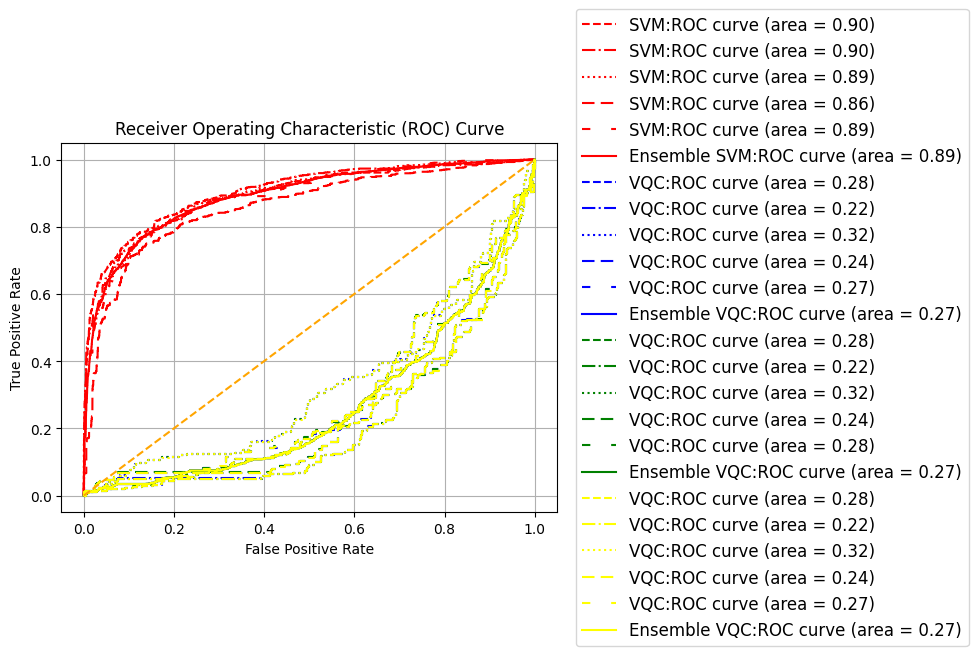

In [106]:
line_styles = ['--', '-.', ':']  # Define different line styles
color = 'red'
for i in range(3):
    plt.plot(fpr_test_batches[i], tpr_test_batches[i], linestyle=line_styles[i], color=color, label='SVM:ROC curve (area = %0.2f)' % auc_test_list[i])
plt.plot(fpr_test_batches[3], tpr_test_batches[3], linestyle='--', dashes=(6, 3), color=color, label='SVM:ROC curve (area = %0.2f)' % auc_test_list[3])
plt.plot(fpr_test_batches[4], tpr_test_batches[4], linestyle='--', dashes=(4, 10), color=color, label='SVM:ROC curve (area = %0.2f)' % auc_test_list[4])
plt.plot(fpr_E, tpr_E, linestyle='-', color='red', label='Ensemble SVM:ROC curve (area = %0.2f)' % ensemble_auc_test)

color = 'blue'
for i in range(3):
    plt.plot(fpr_test_batches_sim[i], tpr_test_batches_sim[i], linestyle=line_styles[i], color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_sim[i])
plt.plot(fpr_test_batches_sim[3], tpr_test_batches_sim[3], linestyle='--', dashes=(6, 3), color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_sim[3])
plt.plot(fpr_test_batches_sim[4], tpr_test_batches_sim[4], linestyle='--', dashes=(4, 10), color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_sim[4])
plt.plot(fpr_E_sim, tpr_E_sim, linestyle='-', color='blue', label='Ensemble VQC:ROC curve (area = %0.2f)' % ensemble_auc_test_sim)

color = 'green'
for i in range(3):
    plt.plot(fpr_test_batches_real[i], tpr_test_batches_real[i], linestyle=line_styles[i], color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_real[i])

plt.plot(fpr_test_batches_real[3], tpr_test_batches_real[3], linestyle='--', dashes=(6, 3), color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_real[3])
plt.plot(fpr_test_batches_real[4], tpr_test_batches_real[4], linestyle='--', dashes=(4, 10), color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_real[4])
plt.plot(fpr_E_real, tpr_E_real, linestyle='-', color='green', label='Ensemble VQC:ROC curve (area = %0.2f)' % ensemble_auc_test_real)

color = 'yellow'
for i in range(3):
    plt.plot(fpr_test_batches_sim_noise[i], tpr_test_batches_sim_noise[i], linestyle=line_styles[i], color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_sim_noise[i])
plt.plot(fpr_test_batches_sim_noise[3], tpr_test_batches_sim_noise[3], linestyle='--', dashes=(6, 3), color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_sim_noise[3])
plt.plot(fpr_test_batches_sim_noise[4], tpr_test_batches_sim_noise[4], linestyle='--', dashes=(4, 10), color=color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_sim_noise[4])
plt.plot(fpr_E_sim_noise, tpr_E_sim_noise, linestyle='-', color='yellow', label='Ensemble VQC:ROC curve (area = %0.2f)' % ensemble_auc_test_sim_noise)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Move the legend to the black space
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
# Add grid to the plot
plt.grid(True)
plt.show()



/tmp/ipykernel_1853928/2358520065.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='black')


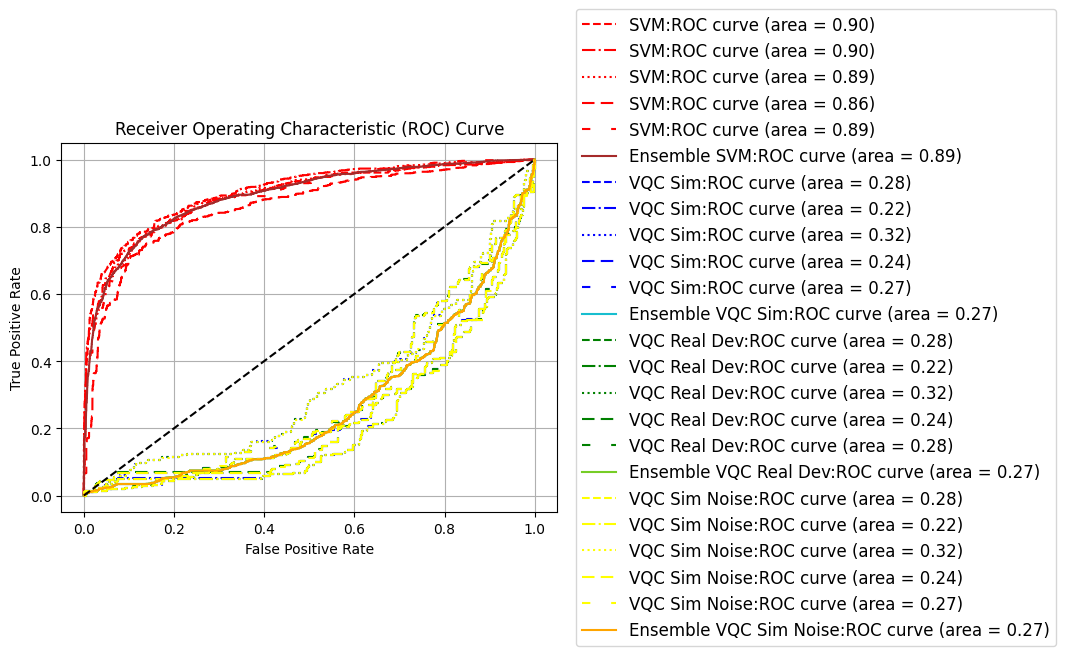

In [126]:
line_styles = ['--', '-.', ':']  # Define different line styles
color = 'red'
for i in range(3):
    plt.plot(fpr_test_batches[i], tpr_test_batches[i], linestyle=line_styles[i], color=color, label='SVM:ROC curve (area = %0.2f)' % auc_test_list[i])
plt.plot(fpr_test_batches[3], tpr_test_batches[3], linestyle='--', dashes=(6, 3), color=color, label='SVM:ROC curve (area = %0.2f)' % auc_test_list[3])
plt.plot(fpr_test_batches[4], tpr_test_batches[4], linestyle='--', dashes=(4, 10), color=color, label='SVM:ROC curve (area = %0.2f)' % auc_test_list[4])
plt.plot(fpr_E, tpr_E, linestyle='-', color='brown', label='Ensemble SVM:ROC curve (area = %0.2f)' % ensemble_auc_test)

color = 'blue'
for i in range(3):
    plt.plot(fpr_test_batches_sim[i], tpr_test_batches_sim[i], linestyle=line_styles[i], color=color, label='VQC Sim:ROC curve (area = %0.2f)' % auc_test_list_sim[i])
plt.plot(fpr_test_batches_sim[3], tpr_test_batches_sim[3], linestyle='--', dashes=(6, 3), color=color, label='VQC Sim:ROC curve (area = %0.2f)' % auc_test_list_sim[3])
plt.plot(fpr_test_batches_sim[4], tpr_test_batches_sim[4], linestyle='--', dashes=(4, 10), color=color, label='VQC Sim:ROC curve (area = %0.2f)' % auc_test_list_sim[4])
plt.plot(fpr_E_sim, tpr_E_sim, linestyle='-', color='tab:cyan', label='Ensemble VQC Sim:ROC curve (area = %0.2f)' % ensemble_auc_test_sim)

color = 'green'
for i in range(3):
    plt.plot(fpr_test_batches_real[i], tpr_test_batches_real[i], linestyle=line_styles[i], color=color, label='VQC Real Dev:ROC curve (area = %0.2f)' % auc_test_list_real[i])

plt.plot(fpr_test_batches_real[3], tpr_test_batches_real[3], linestyle='--', dashes=(6, 3), color=color, label='VQC Real Dev:ROC curve (area = %0.2f)' % auc_test_list_real[3])
plt.plot(fpr_test_batches_real[4], tpr_test_batches_real[4], linestyle='--', dashes=(4, 10), color=color, label='VQC Real Dev:ROC curve (area = %0.2f)' % auc_test_list_real[4])
plt.plot(fpr_E_real, tpr_E_real, linestyle='-', color='xkcd:apple green', label='Ensemble VQC Real Dev:ROC curve (area = %0.2f)' % ensemble_auc_test_real)

color = 'yellow'
for i in range(3):
    plt.plot(fpr_test_batches_sim_noise[i], tpr_test_batches_sim_noise[i], linestyle=line_styles[i], color=color, label='VQC Sim Noise:ROC curve (area = %0.2f)' % auc_test_list_sim_noise[i])
plt.plot(fpr_test_batches_sim_noise[3], tpr_test_batches_sim_noise[3], linestyle='--', dashes=(6, 3), color=color, label='VQC Sim Noise:ROC curve (area = %0.2f)' % auc_test_list_sim_noise[3])
plt.plot(fpr_test_batches_sim_noise[4], tpr_test_batches_sim_noise[4], linestyle='--', dashes=(4, 10), color=color, label='VQC Sim Noise:ROC curve (area = %0.2f)' % auc_test_list_sim_noise[4])
plt.plot(fpr_E_sim_noise, tpr_E_sim_noise, linestyle='-', color='orange', label='Ensemble VQC Sim Noise:ROC curve (area = %0.2f)' % ensemble_auc_test_sim_noise)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Move the legend to the black space
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
# Add grid to the plot
plt.grid(True)
plt.show()

/tmp/ipykernel_1853928/3624843930.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='black')


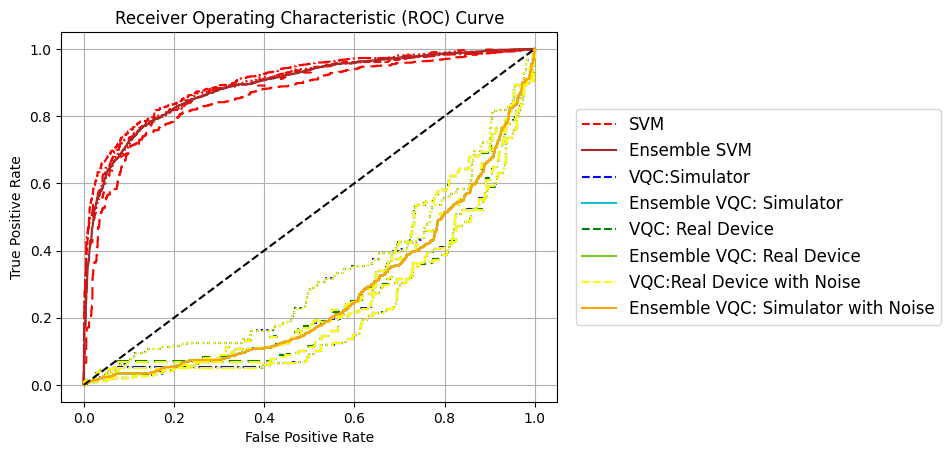

In [125]:
line_styles = ['--', '-.', ':']  # Define different line styles
color = 'red'
for i in range(3):
    if i==0:
        plt.plot(fpr_test_batches[i], tpr_test_batches[i], linestyle=line_styles[i], color=color, label='SVM')
   
    else:
        plt.plot(fpr_test_batches[i], tpr_test_batches[i], linestyle=line_styles[i], color=color)
plt.plot(fpr_test_batches[3], tpr_test_batches[3], linestyle='--', dashes=(6, 3), color=color)
plt.plot(fpr_test_batches[4], tpr_test_batches[4], linestyle='--', dashes=(4, 10), color=color)
plt.plot(fpr_E, tpr_E, linestyle='-', color='brown', label='Ensemble SVM')

color = 'blue'
for i in range(3):
    if i==0:
        plt.plot(fpr_test_batches_sim[i], tpr_test_batches_sim[i], linestyle=line_styles[i], color=color, label='VQC:Simulator')
    else:
        plt.plot(fpr_test_batches_sim[i], tpr_test_batches_sim[i], linestyle=line_styles[i], color=color)
plt.plot(fpr_test_batches_sim[3], tpr_test_batches_sim[3], linestyle='--', dashes=(6, 3), color=color,)
plt.plot(fpr_test_batches_sim[4], tpr_test_batches_sim[4], linestyle='--', dashes=(4, 10), color=color)
plt.plot(fpr_E_sim, tpr_E_sim, linestyle='-', color='tab:cyan', label='Ensemble VQC: Simulator')

color = 'green'
for i in range(3):
    if i==0:
        plt.plot(fpr_test_batches_real[i], tpr_test_batches_real[i], linestyle=line_styles[i], color=color, label='VQC: Real Device')
    plt.plot(fpr_test_batches_real[i], tpr_test_batches_real[i], linestyle=line_styles[i], color=color)

plt.plot(fpr_test_batches_real[3], tpr_test_batches_real[3], linestyle='--', dashes=(6, 3), color=color)
plt.plot(fpr_test_batches_real[4], tpr_test_batches_real[4], linestyle='--', dashes=(4, 10), color=color)
plt.plot(fpr_E_real, tpr_E_real, linestyle='-', color='xkcd:apple green', label='Ensemble VQC: Real Device')

color = 'yellow'
for i in range(3):
    if i==0:
        plt.plot(fpr_test_batches_sim_noise[i], tpr_test_batches_sim_noise[i], linestyle=line_styles[i], color=color, label='VQC:Real Device with Noise')
    plt.plot(fpr_test_batches_sim_noise[i], tpr_test_batches_sim_noise[i], linestyle=line_styles[i], color=color)
plt.plot(fpr_test_batches_sim_noise[3], tpr_test_batches_sim_noise[3], linestyle='--', dashes=(6, 3), color=color)
plt.plot(fpr_test_batches_sim_noise[4], tpr_test_batches_sim_noise[4], linestyle='--', dashes=(4, 10), color=color)
plt.plot(fpr_E_sim_noise, tpr_E_sim_noise, linestyle='-', color='orange',label = 'Ensemble VQC: Simulator with Noise')

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Move the legend to the black space
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
# Add grid to the plot
plt.grid(True)
plt.show()

/tmp/ipykernel_1853928/1460386347.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


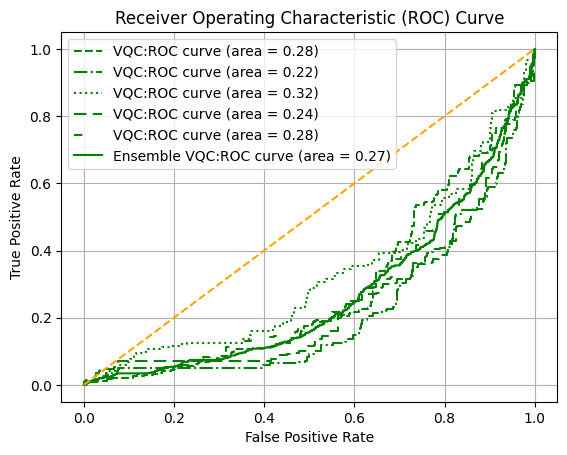

In [107]:
line_styles = [ '--', '-.', ':']  # Define different line styles

color ='green'
for i in range (3):
    plt.plot(fpr_test_batches_real[i], tpr_test_batches_real[i], linestyle=line_styles[i], color = color,label='VQC:ROC curve (area = %0.2f)' % auc_test_list_real[i])
    
plt.plot(fpr_test_batches_real[3], tpr_test_batches_real[3], linestyle='--',dashes = (6,3), color = color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_real[3])
plt.plot(fpr_test_batches_real[4], tpr_test_batches_real[4], linestyle='--',dashes = (4,10), color = color, label='VQC:ROC curve (area = %0.2f)' % auc_test_list_real[4])
plt.plot(fpr_E_real, tpr_E_real, linestyle='-', color = 'green', label='Ensemble VQC:ROC curve (area = %0.2f)' % ensemble_auc_test_real)



# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
# Add grid to the plot
plt.grid(True)
plt.show()